In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
from math import nan, isnan, ceil
import networkx as nx
import re
import statistics
import tabulate
import numpy as np
import pandas as pd

def self_histogram(values: list, normalized: bool = True) -> dict:
    histo_dkt = {}
    for val in values:
        histo_dkt[val] = histo_dkt.get(val, 0)+1
    if normalized:
        for val in histo_dkt:
            histo_dkt[val] = histo_dkt[val]*100/len(values)
    return histo_dkt

def get_info_category() -> dict:
    return {'padec.attribute.SoundLevel': 1,'padec.attribute.Identity': 3, 'padec.attribute.Location': 2}

def parse_info(info: str) -> tuple:
    categories = get_info_category()
    parsed = re.search(
        "(padec.attribute.[a-zA-Z]*|History \(precision [-]?[0-9]*[\.]?[0-9Ee]+\)) from ([^,]*)", info)
    info_type = parsed.group(1)
    host = parsed.group(2)
    if info_type not in categories:
        precision_parsed = re.search("precision ([-]?[0-9]*[\.]?[0-9Ee]+)", info_type)
        if precision_parsed is not None:
            prec_info_type = re.sub(" \(precision [-]?[0-9]*[\.]?[0-9Ee]+\)", "", info_type)
            precision = precision_parsed.group(1)
            return ('Precision', prec_info_type, float(precision), host)
    else:
        return ('Category', info_type, float(categories[info_type]), host)

def read_report(report_file: str):
    g = nx.Graph()
    with open(report_file, 'r') as in_report:
        rep_lines = list(map(lambda x: x.rstrip('\n'), in_report.readlines()))
    rep_lines = rep_lines[2:] # Remove headers
    rep_lines = list(filter(lambda x: x!='', rep_lines)) # Remove empty lines
    for line in rep_lines:
        inf_re = re.search(": \[([^\]]*)\]", line)
        if inf_re is not None:
            infos = inf_re.group(1)
            if infos != '':
                party = re.sub(": \[[^\]]*\]", "", line)
                parsed_infos = list(map(lambda x: parse_info(x), infos.split(", ")))
                if not g.has_node(party):
                    g.add_node(party)
                for p_info in parsed_infos:
                    if p_info[0] == 'Category':
                        if not g.has_edge(party, p_info[3]):
                            g.add_edge(party, p_info[3], category=p_info[2], n_infos=1, sum_cat=p_info[2])
                        else:
                            if g.edges[party, p_info[3]]['category'] < p_info[2]:
                                g.edges[party, p_info[3]]['category'] = p_info[2]
                            g.edges[party, p_info[3]]['n_infos'] += 1
                            g.edges[party, p_info[3]]['sum_cat'] += p_info[2]
                    else:
                        if g.nodes[party].get('precision') is None:
                            g.nodes[party]['precision'] = p_info[2]
                        else:
                            if g.nodes[party]['precision'] > p_info[2]:
                                g.nodes[party]['precision'] = p_info[2]
    return g

def get_max_val() -> float:
    return 1e3

def scale(nums: list) -> list:
    return list(map(lambda x: (x*100)/get_max_val() if x >= -1 else 500, nums))

def def_val(x: str) -> list:
    if x.startswith('C'):
        return 1
    else:
        return 2
    
def generate_legend_artist(color: str, label: str):
    return mpatches.Patch(color=color, label=label)

def all_expr_charts(reports: list, report_labels: list,  bbox: tuple, limits: tuple = None, normalize: bool = True):
    sp1 = plt.subplot(1, 2, 1)
    sp2 = plt.subplot(1, 2, 2)
    data_dkt = {
        'Contextual attributes': {
            'RBAC': 1,
            'ABAC': 3,
            'PADEC': 3
        },
        'Unique rules': {
            'RBAC': 2 + 2**2 + 2**2 + 2**3,
            'ABAC': (2+4+4+4+4)*2 + ((2+4+4+4+4)*2)**2 + ((2+4+4+4+4)*2)**2 + ((2+4+4+4+4)*2)**3,
            'PADEC': (2+4+4+4+4+4+4)*2 + ((2+4+4+4+4+4+4)*2)**2 + ((2+4+4+4+4+4+4)*2)**2 + ((2+4+4+4+4+4+4)*2)**3
        },
        'Unique access levels': {
            'RBAC': 1,
            'ABAC': 1,
            'PADEC': (2+4+4+4+4+4+4)*2 + ((2+4+4+4+4+4+4)*2)**2 + ((2+4+4+4+4+4+4)*2)**2 + ((2+4+4+4+4+4+4)*2)**3
        }
    }
    proxy_df = pd.DataFrame([(key, mech, data_dkt[key][mech]) for key in data_dkt for mech in data_dkt[key]], columns = ['Metric', 'Mechanism', 'Value'])
    proxy_df['Mechanism'] = pd.Categorical(proxy_df['Mechanism'], ['RBAC', 'ABAC', 'PADEC'])
    proxy_df['Metric'] = pd.Categorical(proxy_df['Metric'], ['Contextual attributes', 'Unique rules', 'Unique access levels'])
    proxy_df.pivot("Mechanism", "Metric", "Value").plot(kind='bar', ax=sp1)
    sp1.set_yscale('log')
    sp1.set_xlabel('')
    sp1.set_ylabel('Combinations')
    sp1.yaxis.set_label_coords(-0.15, 0.5)
    sp1.legend(loc='upper center', bbox_to_anchor=bbox)
    
    rep_dkt = {}
    for rep, label in zip(reports, report_labels):
        g = read_report(rep)
        node_vals = [-1*g.nodes[x].get('precision', def_val(x)) for x in g.nodes]
        mv = get_max_val()
        node_vals = [v if v <= mv else mv for v in node_vals]
        node_vals = scale(node_vals)
        node_vals = list(filter(lambda x: x<=100, node_vals))
        histogram = self_histogram(node_vals)
        labeled_histo = {}
        ks = sorted(list(histogram.keys()))
        no_denied = False
        for ndx, k in enumerate(ks):
            if k < 0:
                labeled_histo['Access denied'] = histogram[k]
            else:
                if ndx == 0:
                    no_denied = True
                if no_denied:
                    ndx += 1
                labeled_histo['Access level {}'.format(ndx)] = histogram[k]
        rep_dkt[label] = labeled_histo
    proxy_df = pd.DataFrame([(key, label, rep_dkt[label][key]) for label in rep_dkt for key in rep_dkt[label]], columns=['Access level', 'Test', 'Percentage'])
    proxy_df['Test'] = pd.Categorical(proxy_df['Test'], report_labels)
    al_sorted = sorted(list(dict.fromkeys([key for label in rep_dkt for key in rep_dkt[label]])), key=lambda x: -1 if x == 'Access denied' else int(x.split(' ')[-1]))
    proxy_df['Access level'] = pd.Categorical(proxy_df['Access level'], al_sorted)
    proxy_df.pivot("Test", "Access level", "Percentage").plot.bar(stacked=True, ax=sp2, colormap='viridis')
    sp2.set_xlabel('')
    sp2.set_ylabel('Accesses (%)')
    sp2.yaxis.set_label_coords(-0.13, 0.5)
    sp2.legend(loc='upper center', bbox_to_anchor=bbox, ncol=2)
    sp2.set_ylim((0, 100))
    sp2.set_yticks(list(range(0, 101, 10)))
    
    plt.tight_layout(pad=0)
    plt.savefig('evaluation_figures/Expressiveness.eps', format='eps')
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


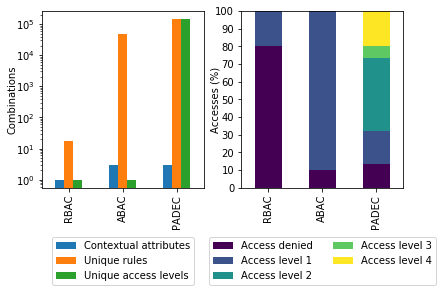

In [29]:
all_expr_charts(['reports/NYCDemoIncremental/step1_rbac_demo_PADECPartyReport.txt',
     'reports/NYCDemoIncremental/step3_abac_demo_PADECPartyReport.txt',
     'reports/Rainbow/rainbow_demo_PADECPartyReport.txt'], 
    ['RBAC',
     'ABAC',
     'PADEC'], (0.5, -0.25))